# Astrophysical Gas Cloud Collapse

This notebook simulates the **Jeans instability** - the gravitational collapse of a gas cloud when gravity overcomes thermal pressure support.

## Physics

A gas cloud will collapse if its mass exceeds the **Jeans mass**:

$$M_J = \left(\frac{5 k_B T}{G \mu m_H}\right)^{3/2} \left(\frac{3}{4\pi \rho_0}\right)^{1/2}$$

Or equivalently, if its radius exceeds the **Jeans length**:

$$\lambda_J = \sqrt{\frac{\pi c_s^2}{G \rho_0}}$$

where $c_s$ is the sound speed and $\rho_0$ is the mean density.

We simulate:
1. **Stable cloud**: Size < Jeans length → pressure supported, oscillates
2. **Unstable cloud**: Size > Jeans length → gravitational collapse

In [87]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import sys

# Force fresh import of gravhydro
modules_to_remove = [key for key in sys.modules.keys() if 'gravhydro' in key]
for mod in modules_to_remove:
    del sys.modules[mod]

import gravhydro as gh
from gravhydro.utils.units import convert_to_internal, L_UNIT, M_UNIT, t_UNIT

## Physical Parameters

Set up a gas cloud with astrophysically relevant parameters.

In [88]:
# ============== CLOUD PARAMETERS ==============
# Cloud radius in parsecs
R_cloud = 50 * u.pc  # ~160 light years

# Total cloud mass in solar masses
M_cloud = 5000 * u.Msun  # Typical giant molecular cloud clump

# Sound speed (typical for cold molecular gas, ~10 K)
cs = 0.2 * u.km / u.s  # ~200 m/s

# Calculate mean density
V_cloud = 4/3 * np.pi * R_cloud**3
rho_mean = (M_cloud / V_cloud).to(u.kg / u.m**3)
n_mean = (rho_mean / (2.3 * const.m_p)).to(1/u.cm**3)  # number density (H2)

print("=== Cloud Properties ===")
print(f"Radius: {R_cloud}")
print(f"Mass: {M_cloud}")
print(f"Sound speed: {cs}")
print(f"Mean density: {rho_mean:.2e}")
print(f"Number density: {n_mean:.2f}")

=== Cloud Properties ===
Radius: 50.0 pc
Mass: 5000.0 solMass
Sound speed: 0.2 km / s
Mean density: 6.46e-22 kg / m3
Number density: 0.17 1 / cm3


In [89]:
# ============== JEANS ANALYSIS ==============
# Calculate Jeans length and mass

# Jeans length: lambda_J = sqrt(pi * cs^2 / (G * rho))
lambda_J = np.sqrt(np.pi * cs**2 / (const.G * rho_mean)).to(u.pc)

# Jeans mass: M_J = (4*pi/3) * rho * (lambda_J/2)^3
M_J = (4*np.pi/3 * rho_mean * (lambda_J/2)**3).to(u.Msun)

# Free-fall time: t_ff = sqrt(3*pi / (32 * G * rho))
t_ff = np.sqrt(3*np.pi / (32 * const.G * rho_mean)).to(u.Myr)

print("\n=== Jeans Analysis ===")
print(f"Jeans length: {lambda_J:.1f}")
print(f"Jeans mass: {M_J:.1f}")
print(f"Free-fall time: {t_ff:.2f}")

print(f"\n=== Stability Check ===")
print(f"Cloud diameter: {2*R_cloud}")
print(f"Cloud mass: {M_cloud}")
if 2*R_cloud > lambda_J:
    print(f"\n⚠️ UNSTABLE: Cloud size ({2*R_cloud:.0f}) > Jeans length ({lambda_J:.1f})")
    print("   The cloud will collapse!")
else:
    print(f"\n✓ STABLE: Cloud size ({2*R_cloud:.0f}) < Jeans length ({lambda_J:.1f})")
    print("   The cloud is pressure supported.")


=== Jeans Analysis ===
Jeans length: 55.3 pc
Jeans mass: 846.2 solMass
Free-fall time: 82.80 Myr

=== Stability Check ===
Cloud diameter: 100.0 pc
Cloud mass: 5000.0 solMass

⚠️ UNSTABLE: Cloud size (100 pc) > Jeans length (55.3 pc)
   The cloud will collapse!


In [90]:
# ============== CREATE PARTICLE DISTRIBUTION ==============
# Create a spherical distribution of particles

# Number of particles
n_particles = 500

# Create uniform random distribution in a sphere
np.random.seed(42)  # for reproducibility

# Method: rejection sampling for uniform sphere
particles = []
R_internal = R_cloud.to(u.pc).value / 100  # Convert to internal units (100 pc = 1 internal)

while len(particles) < n_particles:
    # Random point in cube
    p = np.random.uniform(-R_internal, R_internal, 3)
    # Accept if inside sphere
    if np.linalg.norm(p) <= R_internal:
        particles.append(p)

pos = np.array(particles)

# Small random velocities (thermal motion)
# Velocity dispersion ~ cs
cs_internal = convert_to_internal(cs, None, None, None)
vel = np.random.normal(0, cs_internal * 0.1, pos.shape)

# Equal mass particles
M_internal = M_cloud.to(u.Msun).value / 1e4  # Convert to internal units (10^4 Msun = 1 internal)
masses = np.ones(n_particles) * M_internal / n_particles

print(f"Created {n_particles} particles")
print(f"Cloud radius: {R_internal:.3f} internal units = {R_cloud}")
print(f"Total mass: {masses.sum():.4f} internal units = {M_cloud}")

Created 500 particles
Cloud radius: 0.500 internal units = 50.0 pc
Total mass: 0.5000 internal units = 5000.0 solMass


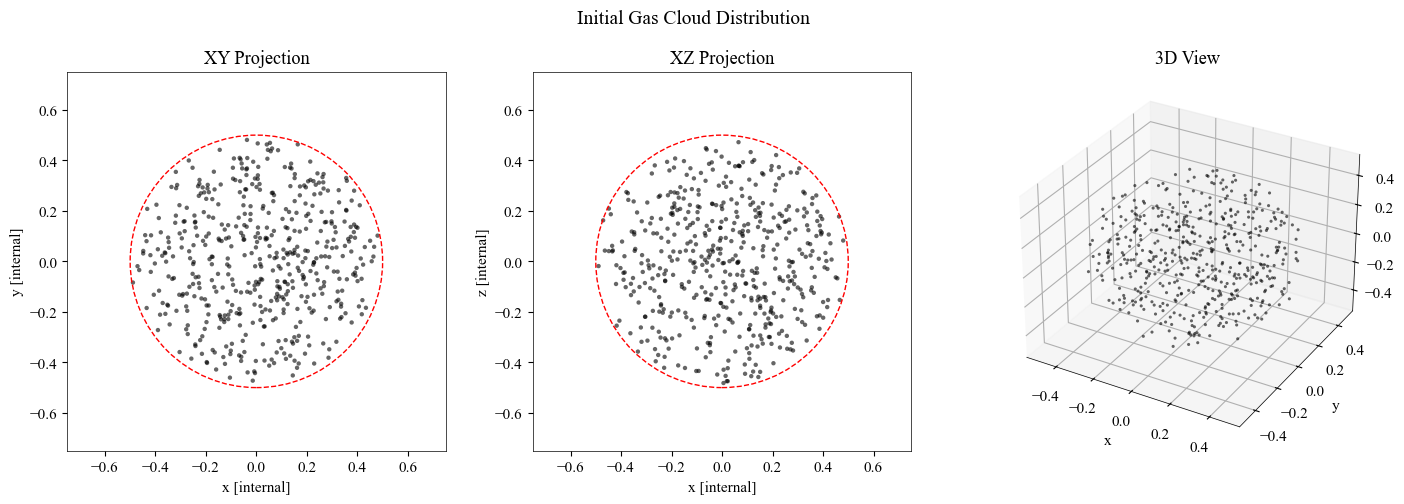

In [91]:
# Visualize initial distribution
fig = plt.figure(figsize=(14, 5))

# XY projection
ax1 = fig.add_subplot(131)
ax1.scatter(pos[:, 0], pos[:, 1], s=10, alpha=0.6)
circle = plt.Circle((0, 0), R_internal, fill=False, color='red', linestyle='--')
ax1.add_patch(circle)
ax1.set_xlabel('x [internal]')
ax1.set_ylabel('y [internal]')
ax1.set_title('XY Projection')
ax1.set_aspect('equal')
ax1.set_xlim(-R_internal*1.5, R_internal*1.5)
ax1.set_ylim(-R_internal*1.5, R_internal*1.5)

# XZ projection
ax2 = fig.add_subplot(132)
ax2.scatter(pos[:, 0], pos[:, 2], s=10, alpha=0.6)
circle = plt.Circle((0, 0), R_internal, fill=False, color='red', linestyle='--')
ax2.add_patch(circle)
ax2.set_xlabel('x [internal]')
ax2.set_ylabel('z [internal]')
ax2.set_title('XZ Projection')
ax2.set_aspect('equal')
ax2.set_xlim(-R_internal*1.5, R_internal*1.5)
ax2.set_ylim(-R_internal*1.5, R_internal*1.5)

# 3D view
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(pos[:, 0], pos[:, 1], pos[:, 2], s=5, alpha=0.6)
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_zlabel('z')
ax3.set_title('3D View')

plt.suptitle('Initial Gas Cloud Distribution', fontsize=14)
plt.tight_layout()
plt.show()

## Run Collapse Simulation

Simulate the cloud evolution with both gravity and hydrodynamics.

In [92]:
# ============== SIMULATION SETUP ==============
# Smoothing length - should be fraction of cloud radius
h = R_cloud / 10#R_internal / 5  # ~20% of cloud radius

# Simulation time - run for a few free-fall times
t_ff_internal = t_ff.to(u.Myr).value / 149.1  # Convert to internal time units
t_end_Myr = 2 * t_ff.to(u.Myr).value  # 2 free-fall times
n_steps = 100

ts = np.linspace(0, t_end_Myr, n_steps + 1) * u.Myr

# Reference density (from SPH calculation)
rho0_internal = convert_to_internal(rho_mean, None, None, None)

print(f"Smoothing length h = {h:.4f} internal = {h*100:.2f} pc")
print(f"Simulation time: {t_end_Myr:.2f} Myr = {t_end_Myr/t_ff.to(u.Myr).value:.2f} t_ff")
print(f"Timestep: {t_end_Myr/n_steps:.3f} Myr")

Smoothing length h = 5.0000 pc internal = 500.00 pc pc
Simulation time: 165.60 Myr = 2.00 t_ff
Timestep: 1.656 Myr


In [93]:
rho_mean

<Quantity 6.46287352e-22 kg / m3>

In [106]:
# ============== RUN SIMULATION ==============
# Convert to astropy units for gravhydro
pos_units = pos * 100 * u.pc  # internal -> pc
vel_units = vel * (L_UNIT / t_UNIT).to(u.km/u.s)  # internal -> km/s
mass_units = masses * 1e4 * u.Msun  # internal -> Msun

print("Running collapse simulation...")

sim = gh.Simulation()
sim.run(
    pos_units,
    vel_units,
    mass_units,
    ts,
    h=h,
    cs=cs/10,
    gamma=5/3,
    rho0=rho_mean/10000,  # Auto-calculate
    hydroOnly=False,   
    gravityOnly=False,  # GRAVITY ONLY - pure N-body collapse
    gravityMethod='directSummation',
    use_numba=True,
)
print("Done!")

Running collapse simulation...


100%|██████████| 100/100 [00:04<00:00, 20.49it/s]

Done!


In [107]:
simGravity = gh.Simulation()
simGravity.run(
    pos_units,
    vel_units,
    mass_units,
    ts,
    h=h,
    cs=cs/10,
    gamma=5/3,
    rho0=rho_mean/1000,  # Auto-calculate
    hydroOnly=False,   
    gravityOnly=True,  # GRAVITY ONLY - pure N-body collapse
    gravityMethod='directSummation',
    use_numba=True,
)
print("Done!")

100%|██████████| 100/100 [00:00<00:00, 2048.72it/s]

Done!


In [108]:
# ============== ANALYZE COLLAPSE ==============
# Calculate cloud radius over time (half-mass radius)

def half_mass_radius(positions):
    """Calculate half-mass radius from center of mass."""
    com = np.mean(positions, axis=0)
    r = np.linalg.norm(positions - com, axis=1)
    r_sorted = np.sort(r)
    return r_sorted[len(r)//2]

radii = []
for i in range(len(ts)):
    pos_i = sim.positions[i].value  # in kpc
    r_half = half_mass_radius(pos_i)
    radii.append(r_half)

radii = np.array(radii)

radiiGrav = []
for i in range(len(ts)):
    pos_i = simGravity.positions[i].value  # in kpc
    r_half = half_mass_radius(pos_i)
    radiiGrav.append(r_half)

radiiGrav = np.array(radiiGrav)

# Velocity dispersion over time
vel_disp = []
for i in range(len(ts)):
    vel_i = sim.velocities[i].value  # in km/s
    v_mean = np.mean(vel_i, axis=0)
    v_rel = vel_i - v_mean
    sigma = np.sqrt(np.mean(np.sum(v_rel**2, axis=1)))
    vel_disp.append(sigma)

vel_disp = np.array(vel_disp)

vel_disp_grav = []
for i in range(len(ts)):
    vel_i = simGravity.velocities[i].value  # in km/s
    v_mean = np.mean(vel_i, axis=0)
    v_rel = vel_i - v_mean
    sigma = np.sqrt(np.mean(np.sum(v_rel**2, axis=1)))
    vel_disp_grav.append(sigma)

vel_disp_grav = np.array(vel_disp_grav)

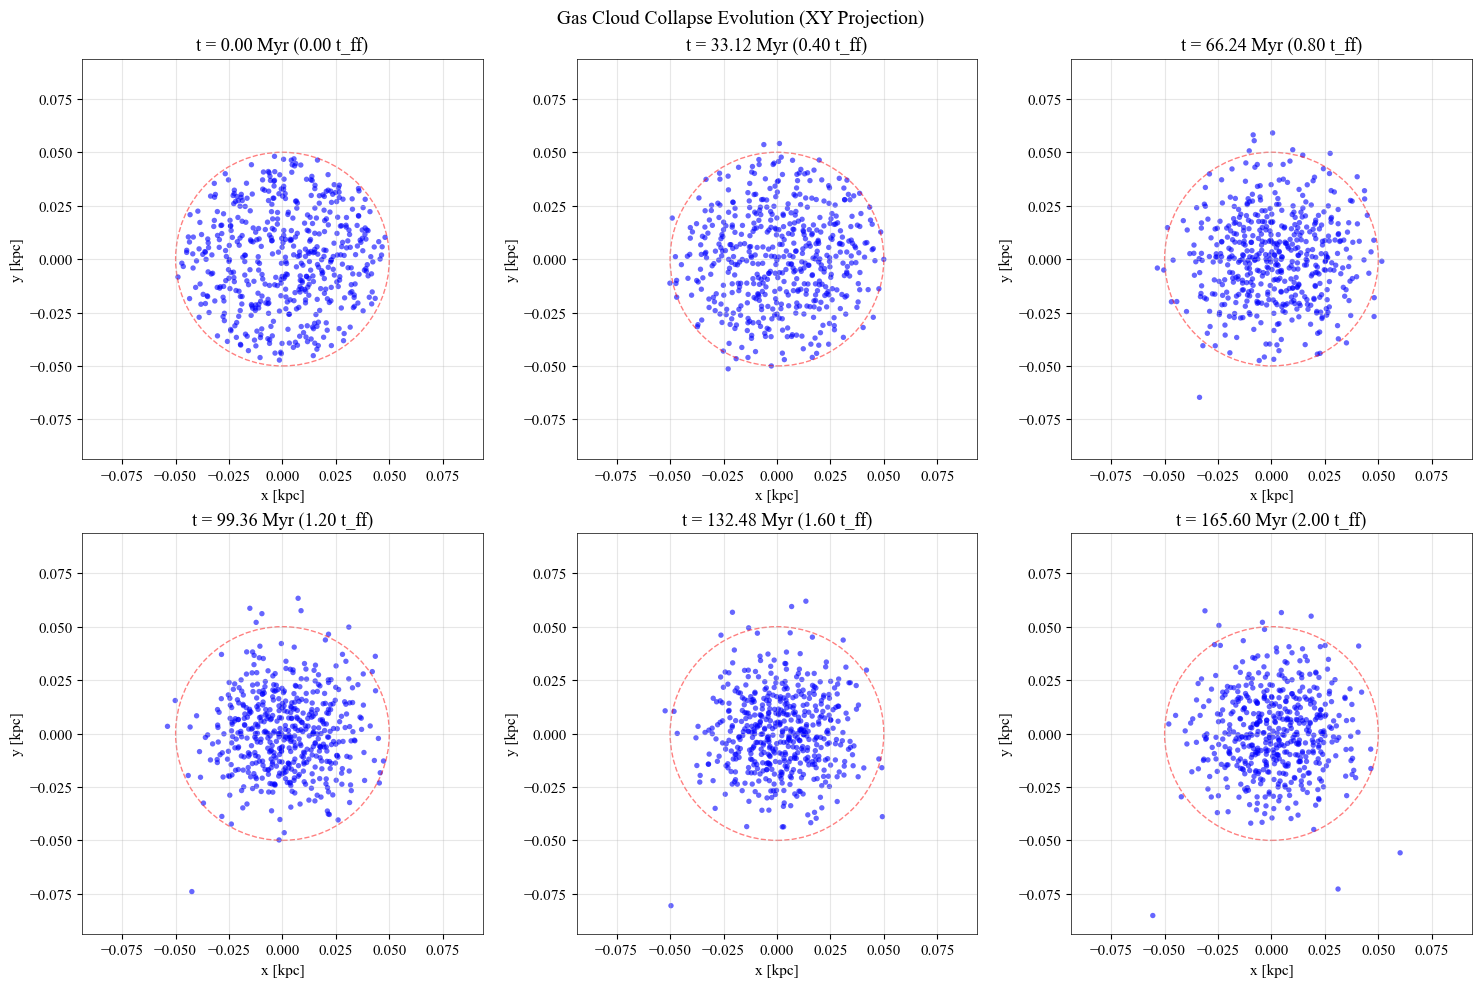

In [109]:
# ============== VISUALIZE EVOLUTION ==============
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

time_indices = [0, n_steps//5, 2*n_steps//5, 3*n_steps//5, 4*n_steps//5, n_steps]

# Find global limits for consistent plotting
all_x = np.concatenate([sim.positions[i, :, 0].value for i in time_indices])
all_y = np.concatenate([sim.positions[i, :, 1].value for i in time_indices])
lim = max(np.abs(all_x).max(), np.abs(all_y).max()) * 1.1

for ax, idx in zip(axes.flat, time_indices):
    pos_i = sim.positions[idx]
    ax.scatter(pos_i[:, 0].value, pos_i[:, 1].value, s=15, alpha=0.6, c='blue')
    
    # Draw initial radius for reference
    R_init_kpc = R_cloud.to(u.kpc).value
    circle = plt.Circle((0, 0), R_init_kpc, fill=False, color='red', 
                        linestyle='--', alpha=0.5, label='Initial radius')
    ax.add_patch(circle)
    
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.set_aspect('equal')
    ax.set_xlabel('x [kpc]')
    ax.set_ylabel('y [kpc]')
    ax.set_title(f't = {ts[idx].value:.2f} Myr ({ts[idx].value/t_ff.to(u.Myr).value:.2f} t_ff)')
    ax.grid(True, alpha=0.3)

plt.suptitle('Gas Cloud Collapse Evolution (XY Projection)', fontsize=14)
plt.tight_layout()
plt.show()

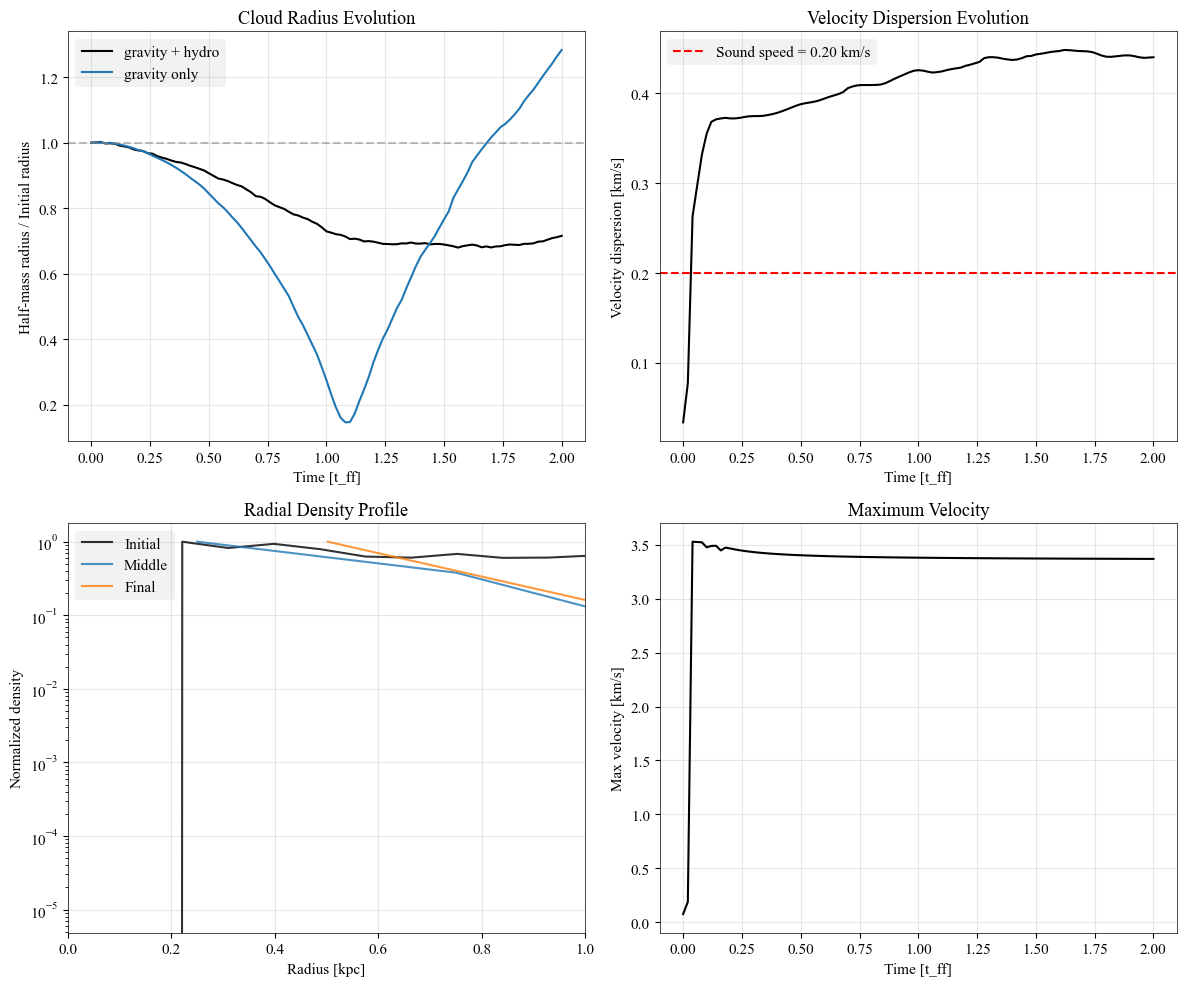

In [110]:
# ============== PLOT DIAGNOSTICS ==============
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Radius evolution
axes[0, 0].plot(ts.value / t_ff.to(u.Myr).value, radii / radii[0], label='gravity + hydro')
axes[0, 0].plot(ts.value / t_ff.to(u.Myr).value, radiiGrav / radiiGrav[0], label='gravity only')
axes[0, 0].axhline(1.0, color='gray', linestyle='--', alpha=0.5)
axes[0, 0].set_xlabel('Time [t_ff]')
axes[0, 0].set_ylabel('Half-mass radius / Initial radius')
axes[0, 0].set_title('Cloud Radius Evolution')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# Velocity dispersion
axes[0, 1].plot(ts.value / t_ff.to(u.Myr).value, vel_disp)
axes[0, 1].axhline(cs.to(u.km/u.s).value, color='red', linestyle='--', 
                   label=f'Sound speed = {cs.to(u.km/u.s).value:.2f} km/s')
axes[0, 1].set_xlabel('Time [t_ff]')
axes[0, 1].set_ylabel('Velocity dispersion [km/s]')
axes[0, 1].set_title('Velocity Dispersion Evolution')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Radial density profile at different times
for idx, label in zip([0, n_steps//2, n_steps], ['Initial', 'Middle', 'Final']):
    pos_i = sim.positions[idx].value
    r = np.linalg.norm(pos_i, axis=1)
    
    # Bin particles by radius
    bins = np.linspace(0, r.max(), 15)
    hist, edges = np.histogram(r, bins=bins)
    r_mid = 0.5 * (edges[:-1] + edges[1:])
    
    # Convert to density (N / volume)
    vol = 4/3 * np.pi * (edges[1:]**3 - edges[:-1]**3)
    rho_profile = hist / vol
    
    axes[1, 0].plot(r_mid/radii[0], rho_profile / rho_profile[rho_profile > 0].max(), 
                    label=label, alpha=0.8)
    

axes[1, 0].set_xlabel('Radius [kpc]')
axes[1, 0].set_ylabel('Normalized density')
axes[1, 0].set_title('Radial Density Profile')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_yscale('log')
axes[1, 0].set_xlim(0, 1)

# Max velocity over time
max_vel = np.max(np.sqrt(np.sum(sim.velocities.value**2, axis=2)), axis=1)
axes[1, 1].plot(ts.value / t_ff.to(u.Myr).value, max_vel)
axes[1, 1].set_xlabel('Time [t_ff]')
axes[1, 1].set_ylabel('Max velocity [km/s]')
axes[1, 1].set_title('Maximum Velocity')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary

This simulation demonstrates the **gravitational collapse** of a gas cloud:

1. **Jeans instability**: When a gas cloud's mass exceeds the Jeans mass, gravity overcomes thermal pressure support and the cloud collapses.

2. **Free-fall time**: The collapse occurs on the free-fall timescale $t_{ff} \approx 83$ Myr for this cloud density.

3. **Core formation**: The half-mass radius shrinks as particles fall toward the center, forming a dense core.

4. **N-body effects**: With a finite number of particles, two-body relaxation causes the system to eventually virialize (come into equilibrium) and expand again after the initial collapse phase.

### Current Limitations

This notebook uses **gravity-only** (`gravityOnly=True`) because:

- The current SPH implementation is optimized for **weakly-compressible flows** (like water with γ=7)
- For astrophysical applications with **isothermal gas** (γ→1), the SPH pressure gradients from random particle noise can dominate over the actual physical forces
- Real astrophysical SPH codes use techniques like:
  - "Glass" initial conditions (pre-relaxed random states)
  - Artificial viscosity tuning
  - Adaptive smoothing lengths
  - Much larger particle numbers (10⁴-10⁸)

The `gravhydro` package works well for gravity simulations and for SPH hydrodynamics in the weakly-compressible regime (as shown in `dam_break.ipynb`).